# Example Signature Notebook

### MSTIC Config

In [1]:
%%writefile msticpyconfig.yaml
AzureSentinel:
  Workspaces:
    ASIHuntOMSWorkspaceV4:
      TenantId: 72f988bf-86f1-41af-91ab-2d7cd011db47
      WorkspaceId: 52b1ab41-869e-4138-9e40-2a4457f09bf0
    CyberSecuritySoc:
      TenantId: 72f988bf-86f1-41af-91ab-2d7cd011db47
      WorkspaceId: 8ecf8077-cf51-4820-aadd-14040956f35d
    Default:
      TenantId: 72f988bf-86f1-41af-91ab-2d7cd011db47
      WorkspaceId: 8ecf8077-cf51-4820-aadd-14040956f35d

Overwriting msticpyconfig.yaml


### Initialize MSTICPy

In [1]:
# Core MSTICPy initialization for Notebooks
from msticpy.nbtools import nbinit
nbinit.init_notebook(namespace=globals());

# Load query providers (typically you'll be using just one)
qry_prov = QueryProvider("AzureSentinel")

Please wait. Loading Kqlmagic extension...


### Connect to Workspace

In [2]:
qry_prov.connect(WorkspaceConfig())

In [3]:
import ipywidgets as widgets

tables = qry_prov.schema_tables
dropdown = widgets.Dropdown(
    options=tables,
    description='Table:',
    value='OfficeActivity'
)

display(dropdown)

Dropdown(description='Table:', index=229, options=('AACAudit', 'AACHttpRequest', 'AADDomainServicesAccountLogo…

### Get the N most recent Rows Store in dataframe

In [4]:
# Get the most recent n rows

nRows = 10000
table = dropdown.value
queryString = f"{table} | take {nRows}"
df = qry_prov.exec_query(queryString)

In [5]:
from signature import DataSignature

s = DataSignature(df)
# Regular expresion to remove is time
s.generateSignatures(regexes=[r'^.*[Tt][Ii][Mm][Ee].*$'])
s.findUniques()

In [7]:
# s.featureMap

In [ ]:

cleanedData = s.cleanedData


# The multiselect element allows the user to choose which features should be present
# i.e. if we want to look at the data which only have tenantid and clientip we would select those
multiSelect = widgets.SelectMultiple(
    options=sorted(list(self.cleanedData)),
    description='Present Features',
    disabled=False
)
display(multiSelect)

# Check if the selected values are a valid combination
if tuple(sorted(multiSelect.value)) not in self.featureMap:
    print("Data signature with those values were not found.")
else:
    dataSignature = self.featureMap[sorted(multiSelect.value)]
    
    porportion = self.signatureDict[dataSignature]['count'] / self.cleanedData.shape[0]
    print(f'% of samples that have this signature: {porportion}%')
    features = self.signatureDict[dataSignature]['featureDict']

    # The dropdown element allows the user to select which feature to visualize
    # i.e. if we have a signature, and we want to see the distribution of different clientIP's within that signature
    # the dropdown allows us to select which value to visualize
    dropdown = widgets.Dropdown(
        options=sorted(list(features.keys())),
        description='Value:',
    )
    display(dropdown)
    plt.bar(features[dropdown.value].keys(), features[dropdown.value].values(), 1, color='g')

In [12]:
cleanedData = s.cleanedData
# list(cleanedData.columns)
featureMap = s.featureMap
# featureMap[]

In [54]:
cleanedData.shape

(10000, 60)

In [117]:
from IPython.display import HTML
import matplotlib.pyplot as plt
from bokeh.plotting import figure
from bokeh.io import output_notebook, show, push_notebook

# output_notebook()

# p = figure(plot_width=400, plot_height=400)
# # p = figure(x_range=fruits, plot_height=250, title="Fruit counts",
# #            toolbar_location=None, tools="")

# # p.vbar(x=fruits, top=counts, width=0.9)
# p.vbar(x=["x", "y", "z"], top=[1.2, 2.5, 3.7], color="navy")

# plot_hnd = show(p, notebook_handle=True)

# define layout
list_layout = widgets.Layout(height="300px", width="30%")

cleanedData = s.cleanedData
featureMap = s.featureMap
signatureDict = s.signatureDict

# create widgets
column_select = widgets.SelectMultiple(
    description="Columns",
    options=sorted(list(cleanedData.columns)),
    layout=list_layout
)

item_select = widgets.Select(
    description="Value",
    options=[],
    layout=list_layout
)

# html widget to display text stuff
feat_status = widgets.HTML()


def get_current_sigs(features):
    matching_sigs = set(featureMap.values())
    for feature in features:
        f_sigs = {sig for feats, sig in featureMap.items() if feature in feats}
        matching_sigs = f_sigs & matching_sigs
    return matching_sigs


def get_sig_items(features):
    data_sigs = get_current_sigs(features)
    return {sig: signatureDict[sig]['featureDict'] for sig in data_sigs}


def get_sig_names(features):

    sig_items = get_sig_items(features)
    items = [set(item.keys()) for item in sig_items.values()]

    all_cols = {col for item in items for col in item}
    common_cols = all_cols.copy()
    for item in items:
        common_cols &= item

    common_cols
    
    # sig_names = set()
    # for sig_item in sig_items.values():
    #     sig_names = sig_names | sig_item.keys()
    return sorted(list(common_cols))


# event handler for table_select
def _get_features(change):
    feature_names = change.get("new")

    data_sigs = get_sig_items(feature_names)
    if not data_sigs:
        feat_status.value = f"Data signature for {feature_names} were not found."
        return

        #dataSignature = self.featureMap[sorted(multiSelect.value)]
    feat_text = [
        f"<h3>Stats for features: {', '.join(feature_names)}</h3>",
        f"Selected columns appear in {len(data_sigs)} sigs, {100 * len(data_sigs)/len(featureMap):0.2f}% of signatures"
    ]

    feat_status.value = "<br>".join(feat_text)

    # The dropdown element allows the user to select which feature to visualize
    # i.e. if we have a signature, and we want to see the distribution of different clientIP's within that signature
    # the dropdown allows us to select which value to visualize
    item_select.options = get_sig_names(feature_names)
        
        
# add event handler to widget   
column_select.observe(_get_features, names="value")


# event handler for col_select
def plot_feature(ax):

    selected = item_select.value
    features = get_sig_items(column_select.value)

    count_dict = {}
    all_values = [
        count_dict 
        for feature in features.values() 
        for val, count_dict in feature.items()
        if val == selected
    ]
    for count_d in all_values:
        count_dict.update(count_d)

    # sig_stats = []
    # for sig, sig_item in sig_items.items():
    #     proportion = 100 * signatureDict[sig]['count'] / cleanedData.shape[0]
    #     sig_stats.append(f'{sig} - {proportion:0.2f}% of signatures that have ???')
    # plot = figure(plot_width=400, plot_height=400)
    # plot.vbar(x=list(features[selected].keys()), height=0.5, left=0,
    #    top=list(features[selected].values()), color="navy")
    # # push_notebook(handle=plot_hnd)
    # plot_html.value = plot._repr_html_()
    ax.clear()
    # print(list(features[selected].values()))
    from matplotlib.ticker import IndexFormatter

    ax.xaxis.set_major_formatter(IndexFormatter(list(count_dict.keys())))

    x = range(len(count_dict.values()))
    ax.bar(x, list(count_dict.values()), color='g')
    ax.tick_params(axis="x", rotation=90)

    plt.show()
    

# add handler
# item_select.observe(_plot_feature, names="value")

# prob a nicer way to do this but we want to force the
# event handlers to be called on the first item so that
# everything is populated when first shown
column_select.value = [column_select.options[0]]

# display widgets using VBox and HBox layout controls
display(
    widgets.VBox([
        widgets.HBox([column_select, item_select]),
        feat_status,
    ])
)

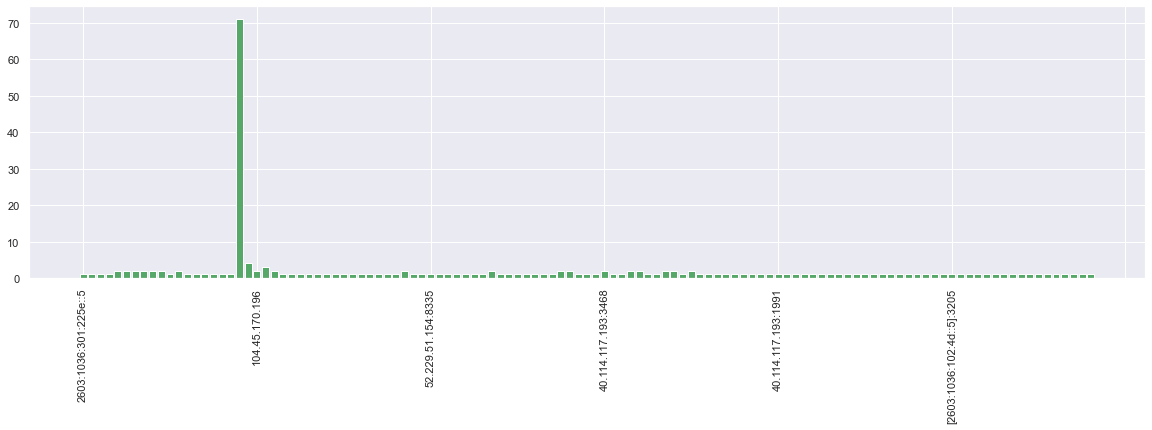

In [118]:
fig, ax = plt.subplots(figsize=(20, 5))
plot_feature(ax)

## Junk test code below

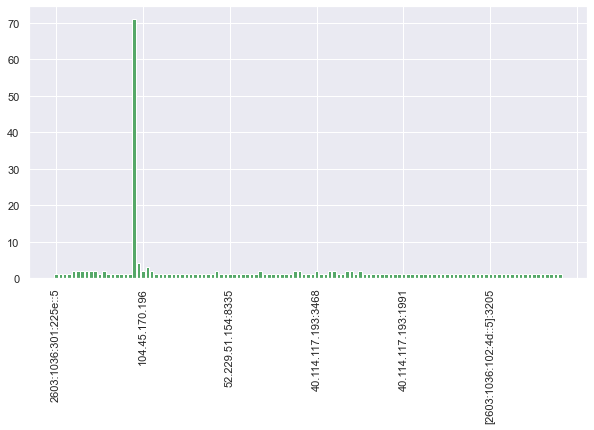

In [102]:
selected = item_select.value
features = get_sig_items(column_select.value)
selected

count_dict = {}
all_values = [count_dict for feature in features.values() for val, count_dict in feature.items() if val == selected]
for count_d in all_values:
    count_dict.update(count_d)
count_dict

count_dict = {}
all_values = [
    count_dict 
    for feature in features.values() 
    for val, count_dict in feature.items()
    if val == selected
]
for count_d in all_values:
    count_dict.update(count_d)

# sig_stats = []
# for sig, sig_item in sig_items.items():
#     proportion = 100 * signatureDict[sig]['count'] / cleanedData.shape[0]
#     sig_stats.append(f'{sig} - {proportion:0.2f}% of signatures that have ???')
# plot = figure(plot_width=400, plot_height=400)
# plot.vbar(x=list(features[selected].keys()), height=0.5, left=0,
#    top=list(features[selected].values()), color="navy")
# # push_notebook(handle=plot_hnd)
# plot_html.value = plot._repr_html_()
ax.clear()
# print(list(features[selected].values()))
from matplotlib.ticker import IndexFormatter
fig, ax = plt.subplots(figsize=(10,5))
ax.xaxis.set_major_formatter(IndexFormatter(list(count_dict.keys())))
width = 0.2
x = range(len(count_dict.values()))
ax.bar(x, list(count_dict.values()), color='g')
ax.tick_params(axis="x", rotation=90)

plt.show()

In [89]:
count_dict.values()

dict_values([1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 71, 4, 2, 3, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [66]:
# _get_features({"new": column_select.value})
get_current_sigs(column_select.value)

# sigs = [
#     '011101001000000000000000000000000000000010000110000110000000',
#  '011111001000000000000000000000000000000010000110000000000000',
#  '011111001000000000000000000000000000000010001110000001110000',
#  '011111001100000000000000000000000000000010000111110000011000',
#  '011111001100000000000000000000000000000010000111111000011000',
# ]

from pprint import pprint

signatureDict[sigs[0]]['featureDict']
sig_items = get_sig_items(column_select.value)
get_sig_names(column_select.value)
features = signatureDict[sigs[3]]['featureDict']
# pprint(features)
key = "OfficeId"
# ax.bar(features[key].keys(), features[key].values(), 1, color='g')
# p.vbar(x=list(features[key].keys()), top=list(features[key].values()))
# push_notebook(handle=plot_hnd)
sig_items.values()
col_names = set()
items = [set(item.keys()) for item in sig_items.values()]

all_cols = {col for item in items for col in item}
common_cols = all_cols.copy()
for item in items:
    common_cols &= item

common_cols

{'ExternalAccess',
 'OfficeId',
 'OfficeWorkload',
 'Operation',
 'OrganizationName',
 'OriginatingServer',
 'RecordType',
 'ResultStatus',
 'UserId',
 'UserKey',
 'UserType'}

In [67]:
from collections import defaultdict
res_dict = defaultdict(int)
sig_items = get_sig_items(column_select.value)
for sig_item in sig_items.values():
    # print(sig_item)
    for col in column_select.value:
        s_dict = sig_item.get(col)
        if not s_dict:
            continue
        for item, count in s_dict.items():
            res_dict[f"{col}: {item}"] += count

res_dict
        
sig_items

{'01111110110000000000111111111100100100100000000000000000010': {'RecordType': {'ExchangeItemGroup': 4},
  'Operation': {'SoftDelete': 3, 'HardDelete': 1},
  'UserType': {'Regular': 4},
  'UserKey': {'100320003EA95AA4': 1,
   '1003200152C92446': 2,
   '100320003F8A6FC7': 1},
  'OfficeWorkload': {'Exchange': 4},
  'ResultStatus': {'Succeeded': 4},
  'UserId': {'adelevan@seccxpninja.onmicrosoft.com': 1,
   'jbritt@contosohotels.com': 2,
   'MeganB@seccxp.ninja': 1},
  'ClientIP': {'2603:1036:301:225e::5': 1,
   '52.149.63.211': 1,
   '2603:1036:305:4415::5': 1,
   '52.142.124.23': 1},
  'ExternalAccess': {'False': 4},
  'OriginatingServer': {'DM6PR06MB5721 (15.20.4200.000)\r\n': 1,
   'SN7PR06MB7310 (15.20.4200.000)\r\n': 2,
   'DM5PR0601MB3686 (15.20.4065.037)\r\n': 1},
  'OrganizationName': {'seccxpninja.onmicrosoft.com': 4},
  'Logon_Type': {'Owner': 4},
  'MailboxGuid': {'94dc36f5-2b28-4bc5-ba4d-1e23023d271b': 1,
   'fbd7a785-0cd3-43f2-be90-ee67a1bc6067': 2,
   '2e8a8fda-0dfb-41a0-be

In [59]:
for sig_item in sig_items.values():
    print("Operation" in sig_item)
    print(sig_item["Operation"])

True
{'SoftDelete': 3, 'HardDelete': 1}
True
{'Create': 21}
True
{'Send': 77, 'ModifyFolderPermissions': 4, 'Create': 1}
True
{'MailItemsAccessed': 1042}
True
{'Set-User': 1147, 'Set-ConditionalAccessPolicy': 371, 'Set-AdminAuditLogConfig': 23, 'Set-TransportConfig': 69, 'Set-MailboxPlan': 621, 'Set-ExchangeAssistanceConfig': 23, 'Set-TenantObjectVersion': 23, 'Add-MailboxPermission': 23, 'Set-OwaMailboxPolicy': 23, 'Set-Mailbox': 759, 'Install-ResourceConfig': 23, 'Install-DataClassificationConfig': 23, 'Set-RecipientEnforcementProvisioningPolicy': 23, 'New-ExchangeAssistanceConfig': 23, 'Install-DefaultSharingPolicy': 23, 'Enable-AddressListPaging': 23, 'Install-AdminAuditLogConfig': 23, 'Set-OrganizationalUnit': 1, 'Set-AcceptedDomain': 2}
True
{'MailItemsAccessed': 4760}
True
{'New-InboxRule': 2, 'Set-Mailbox': 5, 'New-Mailbox': 1}
True
{'Update': 1}
True
{'Send': 1}
True
{'MailItemsAccessed': 19, 'UpdateInboxRules': 3}
True
{'MoveToDeletedItems': 4}
True
{'New-Mailbox': 8, 'New-Co

F:\anaconda\envs\condadev\lib\site-packages\ipykernel_launcher.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  after removing the cwd from sys.path.


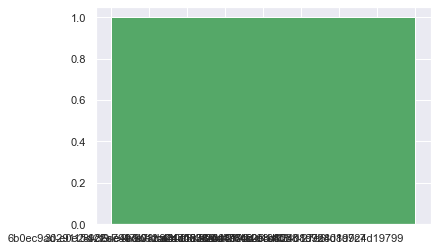

In [32]:
fig, ax = plt.subplots()
ax.clear()
ax.bar(x=list(features[key].values()), height=1, color='g')
ax.set_xticklabels(list(features[key].keys()))
list(features[key].keys())
list(features[key].values())
plt.show()

In [101]:
w = widgets.HTML()
p.vbar(x=list(features[key].keys()), top=list(features[key].values()))
w.value = p._repr_html_()
show(p)